# Version 6t

A complete re-write and re-working of how to choose local standard stars. Now we have the

- Find_Normalisation stars_v1

notebook, and that takes into account all the data as that is combined in the mean master images, we can use the photometry of those master images as the thing to get the normilsation factor to. This does mean that if we take more data we have to choose the normilsation stars agina, but oh well.

This notebook needs to

- Read in for a colour the relevant .csv photometry file.
- Read in a single image photometry file
- For normisation stars, find the correction factor for each star and then the mean and hence the normalised mags for all the stars.

# Version 7

- uses new file structure. DONE

# Version 8t

- Need the bit on SIMBAD based calibration installed and for new .csv to be saved. Get a conversion for RGB but I guess we ignore L? TODO

In [180]:
import numpy as np

import matplotlib
matplotlib.use('TkAgg')

# Set up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import curve_fit

from scipy import optimize
from astropy.time import Time

#from astropy.visualization import time_support
#from astropy.timeseries import TimeSeries

%matplotlib notebook 
import matplotlib.image as mpimg

import pandas as pd

from astropy.io import fits
from astropy.utils.data import download_file

import os
import glob
import time
from matplotlib.colors import LogNorm
from IPython import display
from IPython.display import clear_output

import random

%matplotlib inline
plt.rcParams.update({'font.size':13})

from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

from astropy import units as u
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.aperture import aperture_photometry
from photutils.aperture import ApertureStats

from astropy.wcs import WCS

# conda install -c astropy astroquery

#from astroquery.astrometry_net import AstrometryNet

from astroquery.simbad import Simbad

import astropy.units as u
from astropy import coordinates

import pyvo as vo

import warnings
warnings.filterwarnings("ignore")

from matplotlib.backends.backend_pdf import PdfPages
from astroplan.plots import plot_finder_image

import copy
import math
from My_Functions_v3 import update_fits_header
from My_Functions_v3 import create_or_empty_folder


In [181]:
def print_columns(df):
    """ prints all the column names in a dataframe
        useful for when there's too many and df.columns
        doesn't print them all. """

    for i in range(len(df.columns)):
        print(df.columns[i])
    return()

In [182]:
plot_colours = ['k','r','b','g','c','m','y']

In [28]:
main_star    = "V* RV UMa"
file_object  = "RV_Uma"
file_nights  = ["2022_03_20","2022_03_22","2022_03_24","2023_02_23","2023_04_03"]
save_star = file_object

In [176]:
main_star    = "V* RZ Cas"
file_object  = "RZ_Cas"
file_nights  = ["2023_03_02","2023_04_06","2023_10_14","2023_11_30"]
save_star = file_object

In [31]:
main_star    = "TYC 3023-1747-1"
file_object  = "tyc_3023-1974-1"
file_nights  = ["2023_04_02","2023_04_03"]
save_star = file_object

# Dummy variable
period = 999

In [183]:
main_star    = "V* RZ Cep"
file_object  = "RZ_Cep"
file_nights  = ["2022_12_07", "2023_01_23", "2023_02_23", "2023_11_10", "2024_01_07","2024_01_18"]
save_star = file_object

period = 0.308645
period = 0.308628

In [221]:
main_star    = "V* RZ Cas"
file_object  = "RZ_Cas"
file_nights  = ["2023_03_02","2023_04_06","2023_10_14","2023_11_30"]
#file_nights = ["2023_03_02","2023_04_06"]
#file_nights = ["2023_03_02","2023_04_06","2023_10_14"]
save_star = file_object

period = 1.195247

In [353]:
#colour_list = ["Luminance","Red","Green","Blue"]
colour_list = "Luminance"
colour_list = "Red"
colour_list = "Green"
colour_list = "Blue"

In [354]:
filepath_master = "../../BPO_Data/"+file_object+"/"+colour_list+"/"

composite_image_file = glob.glob(filepath_master+"*weighted_mean.fits")
composite_image_file = composite_image_file[0]

composite_image_file_hdr = fits.getheader(composite_image_file)
composite_photometry_file_normalisation = composite_image_file_hdr['NORMPHOT']


In [355]:
composite_photometry_file_normalisation_filtered = composite_photometry_file_normalisation.replace('.csv','_filtered.csv')
update_fits_header(composite_image_file, 'FILTPHOT', composite_photometry_file_normalisation_filtered, \
                   comment="Photometry with normilsation stars filitered csv")

In [356]:
print(composite_image_file)
print(composite_photometry_file_normalisation)

../../BPO_Data/RZ_Cas/Blue\Composite_RZ_Cas_B_weighted_mean.fits
../../BPO_Data/RZ_Cas/Blue/Composite_RZ_Cas_B_weighted_mean_photometry_solved_normilsation.csv


In [357]:
composite_df_stars = pd.read_csv(composite_photometry_file_normalisation)

In [358]:
composite_image = fits.getdata(composite_image_file)

In [359]:
file_list_individual_matched_csv = []
file_list_imag_red = []
file_list_imag_raw = []
total_files = 0

for file_night in file_nights:
        
        filepath = "../../BPO_Data/"+file_object+"/"+file_night+"/Light/"+colour_list+"/"
        
        create_or_empty_folder(filepath+"photometry_matched_norm/")
        
        for file in glob.glob(filepath+"*.fits"):
            
            hdr_temp = fits.getheader(file)
            
            print(file)
            
            file_list_individual_matched_csv.append(hdr_temp["PHOMATCH"])
            file_list_imag_red.append(hdr_temp["REDIMAGE"])
            file_list_imag_raw.append(file)
print('total number of files = '+str(len(file_list_individual_matched_csv)))
print(print("\n".join(file_list_individual_matched_csv)))  

Folder '../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue/photometry_matched_norm/' has been created.
../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue\RZ_Cas_Light_Blue_0.600_secs_001.fits
../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue\RZ_Cas_Light_Blue_0.600_secs_002.fits
../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue\RZ_Cas_Light_Blue_0.600_secs_003.fits
../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue\RZ_Cas_Light_Blue_0.600_secs_004.fits
../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue\RZ_Cas_Light_Blue_0.600_secs_005.fits
../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue\RZ_Cas_Light_Blue_0.600_secs_006.fits
../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue\RZ_Cas_Light_Blue_0.600_secs_007.fits
../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue\RZ_Cas_Light_Blue_0.600_secs_008.fits
../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue\RZ_Cas_Light_Blue_0.600_secs_009.fits
../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue\RZ_Cas_Light_Blue_0.600_secs_010.fits
../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue\RZ_Cas_Light_Blue_0.600_secs_011.fits
Fo

KeyError: "Keyword 'PHOMATCH' not found."

Open all individual files into a single df, then see how many images each possibile local-standard appears in. If it's below some threshold then set that star to not be a normilsation star.

In [360]:
i = 0
for file in file_list_individual_matched_csv:
    df_temp = pd.read_csv(file)
    if sum(df_temp['MAIN_ID'] == main_star) >= 1:
    
        if i == 0:
            df_data = pd.read_csv(file)
            i = i + 1
        else:
            i = i + 1
            df_data = pd.concat([df_data,pd.read_csv(file)],ignore_index=True)
    else:
        print('no main star'+file)

In [361]:
total_number_images = len(file_list_individual_matched_csv)
print(total_number_images)

82


What fraction of images do stars need to be nicely measured in to be considered normilisation stars? Set to 1 for them to need ot be in all images

In [365]:
fraction_above = 0.7

In [366]:
composite_df_stars_cut1 = composite_df_stars.copy()

In [367]:
saturated = 1

for ind in composite_df_stars_cut1.index:
    if composite_df_stars_cut1['Normilsation_star'][ind] == True:
        if df_data['Source_Mag'].where( \
                (df_data['id_ref'] == composite_df_stars_cut1['id'][ind]) &  \
                (df_data['Saturated'] == saturated)).count() >= total_number_images*fraction_above:
            print('star id =' + str(composite_df_stars_cut1['id'][ind]) + \
                  ', name = ' + str(composite_df_stars_cut1['MAIN_ID'][ind]) + \
                  ', number of images = '+ str(df_data['Source_Mag'].where( \
                (df_data['id_ref'] == composite_df_stars_cut1['id'][ind]) &  \
                (df_data['Saturated'] == saturated)).count()   )+', Fraction = '+str(100 * df_data['Source_Mag'].where( \
                (df_data['id_ref'] == composite_df_stars_cut1['id'][ind]) &  \
                (df_data['Saturated'] == saturated)).count() / total_number_images)    )
         
        else:
            composite_df_stars_cut1['Normilsation_star'][ind] = False
            composite_df_stars_cut1['Normilsation_star_reason'][ind] = 'Does not appear in enough images'
                


star id =9, name = TYC 4317-1437-1, number of images = 82, Fraction = 100.0
star id =14, name = TYC 4316-15-1, number of images = 75, Fraction = 91.46341463414635
star id =15, name = nan, number of images = 70, Fraction = 85.36585365853658


In [375]:
i = 1

j=0

for file in file_list_individual_matched_csv:
    clear_output(wait=True)
    print(i,len(file_list_individual_matched_csv))
    i = i + 1
    print(file)
    
    df_individual_star = pd.read_csv(file)
    
    df_individual_star['Nom_factor'] = np.nan
    df_individual_star['Nom_factor_ERROR'] = np.nan
    df_individual_star['Nom_factor_WEIGHT'] = np.nan
    df_individual_star['Mean_Norm_Factor'] = np.nan
    df_individual_star['Mean_Norm_Factor_ERROR'] = np.nan
    df_individual_star['Circ_sum_flux_minus_back_norm'] = np.nan
    df_individual_star['Circ_sum_flux_minus_back_ERROR_norm'] = np.nan
    df_individual_star['Source_Mag_norm'] = np.nan
    df_individual_star['Source_Mag_Error_norm'] = np.nan
    
    for ind in df_individual_star.index:
        row_index = composite_df_stars_cut1.index.get_loc(composite_df_stars_cut1[composite_df_stars_cut1['id'] ==  df_individual_star['id_ref'][ind]].index[0])
      #  print(row_index)
       # print(composite_df_stars['id'][row_index], df_individual_star['id_ref'][ind])
        #print(composite_df_stars['Normilsation_star'][row_index] )
        if composite_df_stars_cut1['Normilsation_star'][row_index] == True:
            
            df_individual_star['Nom_factor'][ind] = \
            composite_df_stars_cut1['Circ_sum_flux_minus_back'][row_index] / \
            df_individual_star['Circ_sum_flux_minus_back'][ind]
            
            df_individual_star['Nom_factor_ERROR'][ind] = \
            (df_individual_star['Circ_sum_flux_minus_back_ERROR'][ind] * composite_df_stars_cut1['Circ_sum_flux_minus_back'][row_index]) / \
            (df_individual_star['Circ_sum_flux_minus_back'][ind] * df_individual_star['Circ_sum_flux_minus_back'][ind])
             
            df_individual_star['Nom_factor_WEIGHT'][ind] = 1/\
             (df_individual_star['Nom_factor_ERROR'][ind] * df_individual_star['Nom_factor_ERROR'][ind])
            
            
    df_individual_star['Mean_Norm_Factor'] = np.nansum(df_individual_star['Nom_factor'] * df_individual_star['Nom_factor_WEIGHT']) / \
    np.nansum( df_individual_star['Nom_factor_WEIGHT'])
            
    df_individual_star['Mean_Norm_Factor_ERROR'] = np.sqrt( 1/ \
                                                           np.nansum( df_individual_star['Nom_factor_WEIGHT']) )                                                                                                  
                                                                                                                  
    df_individual_star['Circ_sum_flux_minus_back_norm'] = df_individual_star['Circ_sum_flux_minus_back'] * df_individual_star['Mean_Norm_Factor']
    
    df_individual_star['Circ_sum_flux_minus_back_ERROR_norm'] = np.sqrt(\
            (df_individual_star['Mean_Norm_Factor'] *df_individual_star['Circ_sum_flux_minus_back_ERROR'] )**2 + \
            (df_individual_star['Circ_sum_flux_minus_back'] * df_individual_star['Mean_Norm_Factor_ERROR'] )**2)
    
    df_individual_star['Source_Mag_norm'] = -2.5*np.log10(df_individual_star['Circ_sum_flux_minus_back_norm'])
    
    df_individual_star['Source_Mag_Error_norm'] = -2.5 * df_individual_star['Circ_sum_flux_minus_back_ERROR_norm']  / \
    (df_individual_star['Circ_sum_flux_minus_back_norm'] * np.log(10))
            
######
    file_name = os.path.basename(file)
    new_file_name = file_name.replace('.csv','_norm.csv')
            
    filepath = "../../BPO_Data/"+file_object+"/"+file_night+"/Light/"+colour_list+"/"
            
            
    csv_filename = filepath + "photometry_matched_norm/" + new_file_name
    update_fits_header(file_list_imag_raw[j], 'PHONORM', csv_filename, comment="The reduced image photometry matched ot the master and with normilsaiton factor")
    j=j+1
########   
    
    print(csv_filename)
    df_individual_star.to_csv(csv_filename)
    time.sleep(0.01)

82 82
../../BPO_Data/RZ_Cas/2023_11_30/Light/Blue/photometry_matched/RZ_Cas_Light_Blue_0.400_secs_057_photometry_matched.csv
../../BPO_Data/RZ_Cas/2023_10_14/Light/Blue/photometry_matched_norm/RZ_Cas_Light_Blue_0.400_secs_057_photometry_matched_norm.csv


# Phasing

Let's do some folding etc.

In [376]:
file_list_individual_matched_norm_csv = []
file_list_imag = []
total_files = 0

for file_night in file_nights:
        
        filepath = "../../BPO_Data/"+file_object+"/"+file_night+"/Light/"+colour_list+"/"
        
        
        for file in glob.glob(filepath+"*.fits"):
            
            hdr_temp = fits.getheader(file)
            
            print(file)
            
            file_list_individual_matched_norm_csv.append(hdr_temp["PHONORM"])
            file_list_imag.append(hdr_temp["REDIMAGE"])

print('total number of files = '+str(len(file_list_individual_matched_norm_csv)))
print(print("\n".join(file_list_individual_matched_norm_csv)))  

../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue\RZ_Cas_Light_Blue_0.600_secs_001.fits
../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue\RZ_Cas_Light_Blue_0.600_secs_002.fits
../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue\RZ_Cas_Light_Blue_0.600_secs_003.fits
../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue\RZ_Cas_Light_Blue_0.600_secs_004.fits
../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue\RZ_Cas_Light_Blue_0.600_secs_005.fits
../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue\RZ_Cas_Light_Blue_0.600_secs_006.fits
../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue\RZ_Cas_Light_Blue_0.600_secs_007.fits
../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue\RZ_Cas_Light_Blue_0.600_secs_008.fits
../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue\RZ_Cas_Light_Blue_0.600_secs_009.fits
../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue\RZ_Cas_Light_Blue_0.600_secs_010.fits
../../BPO_Data/RZ_Cas/2023_03_02/Light/Blue\RZ_Cas_Light_Blue_0.600_secs_011.fits
../../BPO_Data/RZ_Cas/2023_04_06/Light/Blue\RZ_Cas_Light_Blue_0.600_secs_001.fits
../../BPO_Data/R

KeyError: "Keyword 'PHONORM' not found."

Mark a new df of all the data for this star and filter.

In [377]:
i = 0
for file in file_list_individual_matched_norm_csv:
    df_temp = pd.read_csv(file)
    if sum(df_temp['MAIN_ID'] == main_star) >= 1:
    
        if i == 0:
            df_data = pd.read_csv(file)
            i = i + 1
        else:
            i = i + 1
            df_data = pd.concat([df_data,pd.read_csv(file)],ignore_index=True)
    else:
        print('no main star'+file)
df_data

,Unnamed: 0.1,Unnamed: 0,index,id,xcenter,ycenter,aperture_sum,Circ_sum_flux,Circ_area (reduced pixs),Max_Flux,...,MAIN_ID,Nom_factor,Nom_factor_ERROR,Nom_factor_WEIGHT,Mean_Norm_Factor,Mean_Norm_Factor_ERROR,Circ_sum_flux_minus_back_norm,Circ_sum_flux_minus_back_ERROR_norm,Source_Mag_norm,Source_Mag_Error_norm
0,0,0,9,10,2048.987262,1237.986549,3029.173533,3029.173533,138.020633,131.525543,...,TYC 4317-1482-1,NaN,NaN,NaN,0.703338,0.028311,1511.509339,101.703799,-7.948527,-0.073055
1,1,1,4,6,2212.810802,1115.832042,4897.803817,4897.803817,138.020633,181.240875,...,TYC 4317-1400-1,NaN,NaN,NaN,0.703338,0.028311,2835.787185,145.801360,-8.631684,-0.055823
2,2,2,8,8,1071.855563,977.544361,3666.684148,3666.684148,138.020633,184.938553,...,TYC 4317-1437-1,0.686120,0.029271,1167.177514,0.703338,0.028311,1985.480377,116.455454,-8.244664,-0.063682
3,3,3,5,7,1546.867007,1490.462567,4534.525174,4534.525174,138.020633,197.270294,...,BD+69 176B,NaN,NaN,NaN,0.703338,0.028311,2421.178233,132.527648,-8.460067,-0.059430
4,4,4,10,13,1257.033620,1580.100045,2648.572135,2648.572135,138.020633,94.902351,...,TYC 4316-2034-1,NaN,NaN,NaN,0.703338,0.028311,1137.118147,92.536260,-7.639514,-0.088355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381,11,11,3,4,1504.966935,1633.165081,5879.066632,5879.066632,174.655051,187.471313,...,TYC 4317-1496-1,NaN,NaN,NaN,1.723075,0.228245,7672.649423,1070.476507,-9.712363,-0.151480
1382,12,12,2,3,1694.275884,1577.575255,8380.398465,8380.398465,174.655051,335.779541,...,BD+68 197,NaN,NaN,NaN,1.723075,0.228245,11649.441426,1585.257382,-10.165763,-0.147747
1383,13,13,10,13,2299.653300,1477.894956,2268.418674,2268.418674,174.655051,89.114861,...,TYC 4313-537-1,NaN,NaN,NaN,1.723075,0.228245,1750.874776,370.845226,-8.108138,-0.229965
1384,14,14,17,12,979.802567,294.608346,1932.656930,1932.656930,174.655051,66.811127,...,NaN,2.464182,1.212537,0.680159,1.723075,0.228245,589.493201,300.395376,-6.926197,-0.553272


Now work out time since first measurement

In [378]:
df_data['Obs_Date'] = pd.to_datetime(df_data['Date Observation'])
time_first_obs = df_data['Obs_Date'][0]

df_data['Time_since_first'] = (df_data['Obs_Date'] - time_first_obs).apply(lambda x: 
                                                                         x/np.timedelta64(1, 'h')).fillna(0)
df_data['Time_since_first'] = df_data['Time_since_first'] - df_data['Time_since_first'].min()

Plot

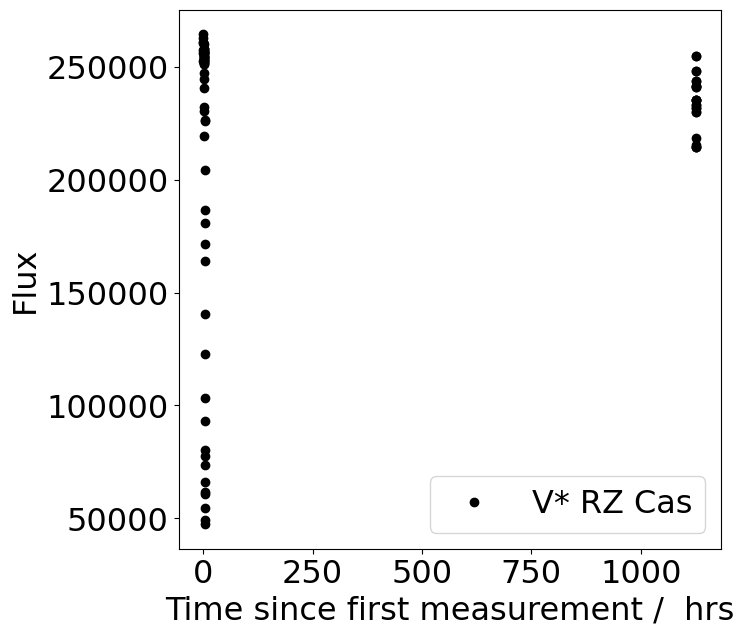

In [379]:
plt.rcParams.update({'font.size':23})

fig = plt.figure(figsize=(7,7))

which_star = main_star

saturated = 1


plt.subplot(1,1,1)
plt.plot(df_data['Time_since_first'].where(\
    (df_data['MAIN_ID'] == which_star) & \
    (df_data['Saturated'] == saturated)), \
    df_data['Circ_sum_flux_minus_back'].where( \
    (df_data['MAIN_ID'] == which_star)& \
    (df_data['Saturated'] == saturated)),'ok',label=which_star)
plt.ylabel('Norm_T_f '+which_star)


plt.xlabel('Time since first measurement /  hrs')
#plt.gca().invert_yaxis()
plt.ylabel('Flux')
plt.legend()
plt.show()


plt.show()

In [380]:

df_data['Phase'] = df_data['Time_since_first'] / (period*24) - np.floor(df_data['Time_since_first'] / (period*24))
df_data['Phase number'] = np.floor(df_data['Time_since_first'] / (period*24))

In [381]:
phase_days = pd.unique(df_data['Phase number'].where( (df_data['MAIN_ID'] == main_star) ))
print(phase_days)
phase_days = phase_days[~np.isnan(phase_days)]
print(phase_days)

[nan 39.  0.]
[39.  0.]


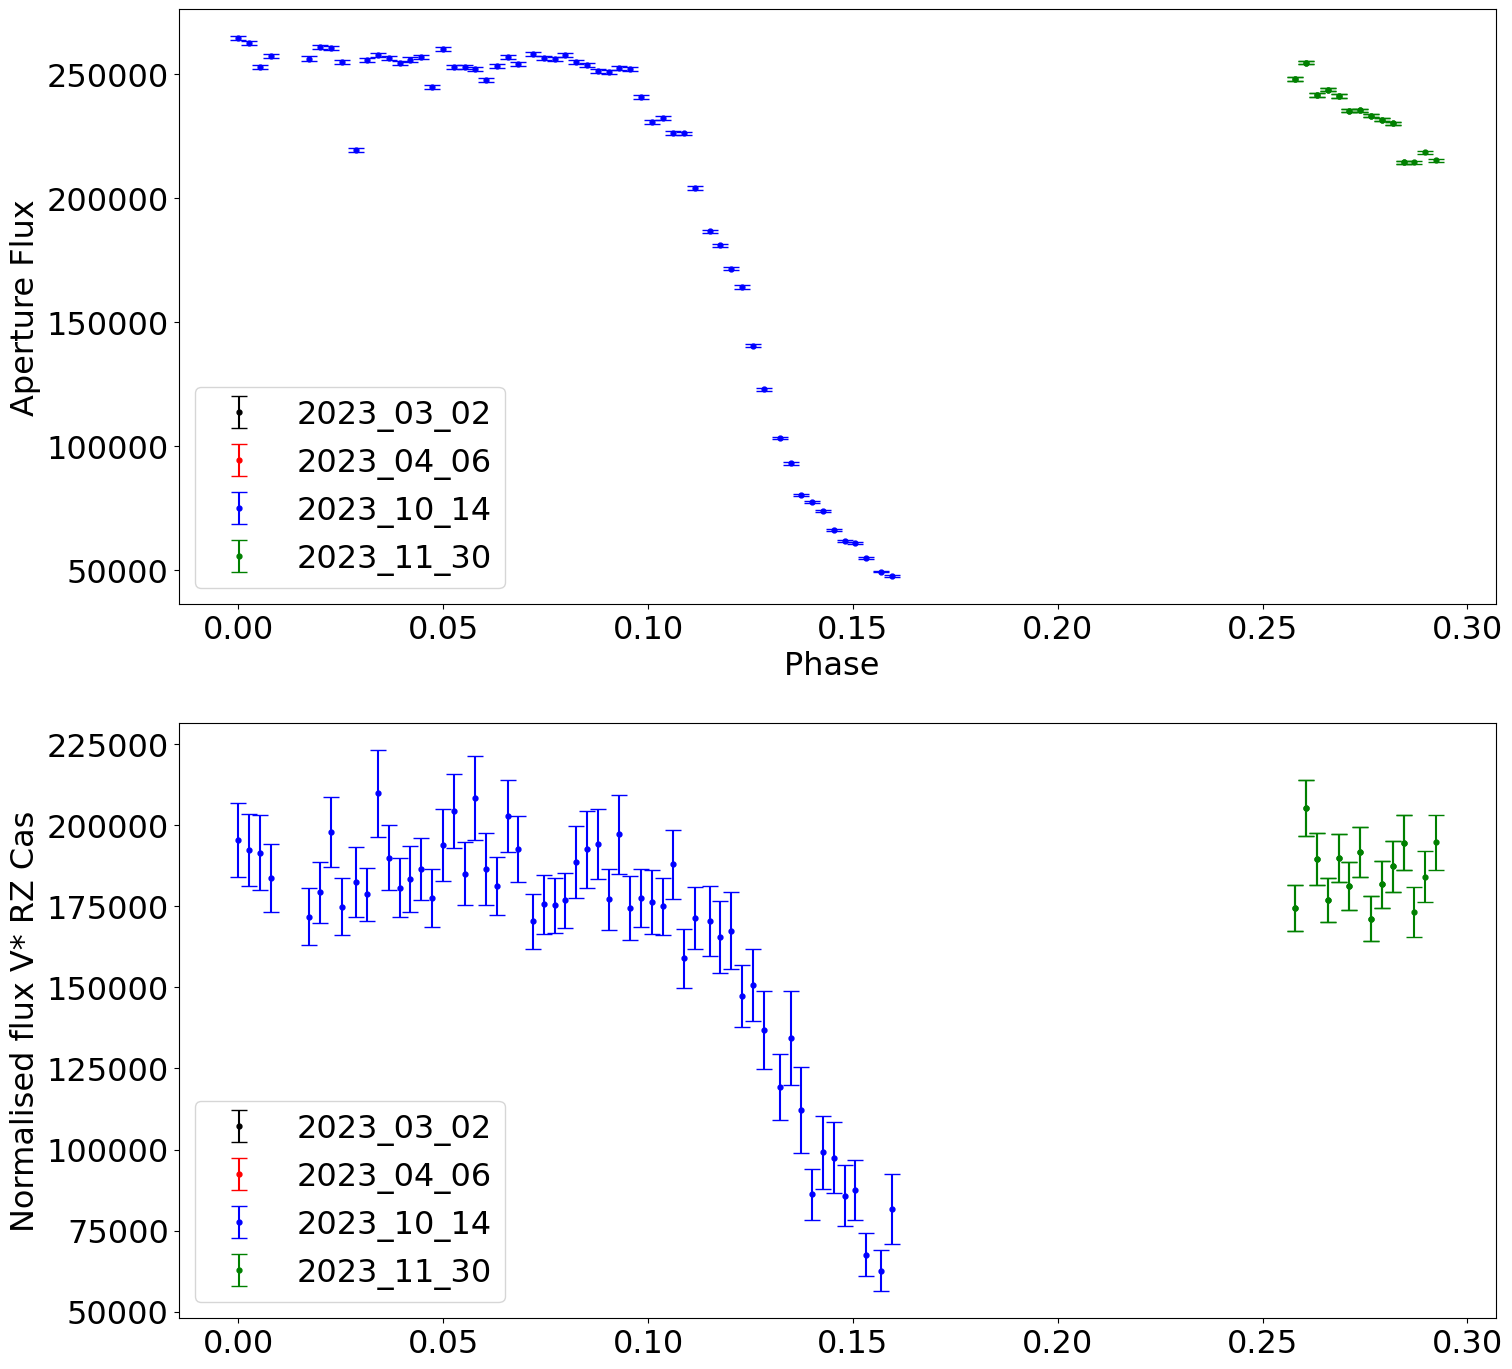

In [382]:
plt.rcParams.update({'font.size':23})

fig = plt.figure(figsize=(17,17))

which_star = main_star

saturated = 1


plt.subplot(2,1,1)
i=0
for file_night in file_nights:

    plt.errorbar(df_data['Phase'].where( \
        (df_data['MAIN_ID'] == which_star) & \
        (df_data['File'].str.contains(file_night)) & \
        (df_data['Saturated'] == saturated)) , \
        df_data['Circ_sum_flux_minus_back'].where( \
        (df_data['MAIN_ID'] == which_star) &  \
        (df_data['File'].str.contains(file_night)) & \
        (df_data['Saturated'] == saturated)),\
        yerr=df_data['Circ_sum_flux_minus_back_ERROR'].where( \
        (df_data['MAIN_ID'] == which_star) & \
        (df_data['File'].str.contains(file_night)) & \
        (df_data['Saturated'] == saturated)), \
        label=file_night,\
        marker='.',             # marker used is a cicle 'o'. Could be crosses 'x', or squares 's', or 'none'
        markersize = 7,        # marker size
        color=plot_colours[i],          # overall colour I think
        ecolor=plot_colours[i],         # edge colour for you marker
        markerfacecolor=plot_colours[i],
        linestyle='none',       # no line joining markers, could be a line '-', or a dashed line '--'
        capsize=6,              # width of the end bit of the error bars, not too small nor too big please.
    )
    i=i+1

plt.xlabel('Phase ')
#plt.gca().invert_yaxis()
plt.ylabel('Aperture Flux')
plt.legend()

plt.subplot(2,1,2)

i=0
for file_night in file_nights:
    
    plt.errorbar(df_data['Phase'].where( \
        (df_data['MAIN_ID'] == which_star) & \
        (df_data['File'].str.contains(file_night)) & \
        (df_data['Saturated'] == saturated)) , \
        df_data['Circ_sum_flux_minus_back_norm'].where( \
        (df_data['MAIN_ID'] == which_star) &  \
        (df_data['File'].str.contains(file_night)) & \
        (df_data['Saturated'] == saturated)),\
        yerr=df_data['Circ_sum_flux_minus_back_ERROR_norm'].where( \
        (df_data['MAIN_ID'] == which_star) & \
        (df_data['File'].str.contains(file_night)) & \
        (df_data['Saturated'] == saturated)), \
        label=file_night,\
        marker='.',             # marker used is a cicle 'o'. Could be crosses 'x', or squares 's', or 'none'
        markersize = 7,        # marker size
        color=plot_colours[i],          # overall colour I think
        ecolor=plot_colours[i],         # edge colour for you marker
        markerfacecolor=plot_colours[i],
        linestyle='none',       # no line joining markers, could be a line '-', or a dashed line '--'
        capsize=6,              # width of the end bit of the error bars, not too small nor too big please.
    )
    i=i+1
plt.ylabel('Normalised flux '+which_star)
plt.legend()
plt.show()



In [383]:
new_file_name = composite_image_file.replace('.fits','_flux.png')
fig.savefig(new_file_name, dpi=300,bbox_inches='tight') # save the graph to a file.

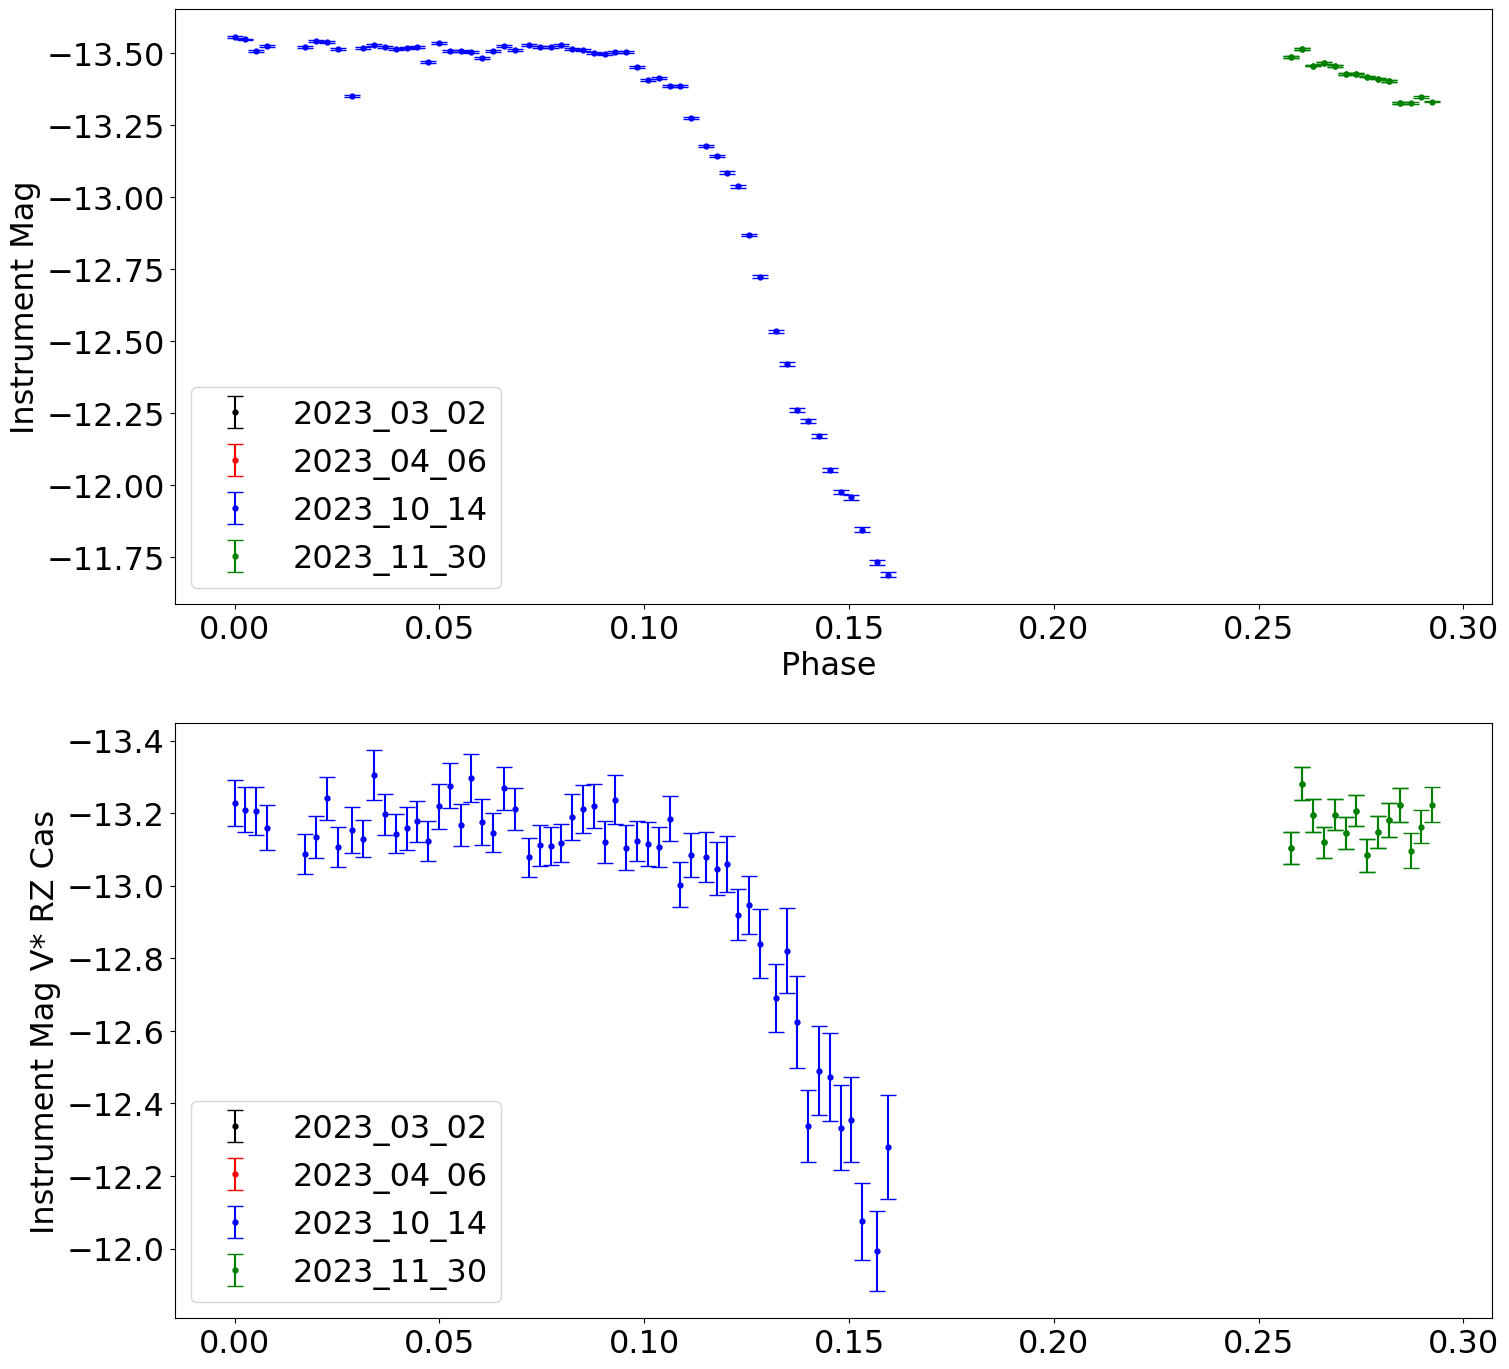

In [384]:
plt.rcParams.update({'font.size':23})

fig = plt.figure(figsize=(17,17))

which_star = main_star

saturated = 1


plt.subplot(2,1,1)
i=0
for file_night in file_nights:

    plt.errorbar(df_data['Phase'].where( \
        (df_data['MAIN_ID'] == which_star) & \
        (df_data['File'].str.contains(file_night)) & \
        (df_data['Saturated'] == saturated)) , \
        df_data['Source_Mag'].where( \
        (df_data['MAIN_ID'] == which_star) &  \
        (df_data['File'].str.contains(file_night)) & \
        (df_data['Saturated'] == saturated)),\
        yerr=df_data['Source_Mag_Error'].where( \
        (df_data['MAIN_ID'] == which_star) & \
        (df_data['File'].str.contains(file_night)) & \
        (df_data['Saturated'] == saturated)), \
        label=file_night,\
        marker='.',             # marker used is a cicle 'o'. Could be crosses 'x', or squares 's', or 'none'
        markersize = 7,        # marker size
        color=plot_colours[i],          # overall colour I think
        ecolor=plot_colours[i],         # edge colour for you marker
        markerfacecolor=plot_colours[i],
        linestyle='none',       # no line joining markers, could be a line '-', or a dashed line '--'
        capsize=6,              # width of the end bit of the error bars, not too small nor too big please.
    )
    i=i+1

plt.xlabel('Phase ')
plt.gca().invert_yaxis()
plt.ylabel('Instrument Mag')
plt.legend()

plt.subplot(2,1,2)

i=0
for file_night in file_nights:
    
    plt.errorbar(df_data['Phase'].where( \
        (df_data['MAIN_ID'] == which_star) & \
        (df_data['File'].str.contains(file_night)) & \
        (df_data['Saturated'] == saturated)) , \
        df_data['Source_Mag_norm'].where( \
        (df_data['MAIN_ID'] == which_star) &  \
        (df_data['File'].str.contains(file_night)) & \
        (df_data['Saturated'] == saturated)),\
        yerr=df_data['Source_Mag_Error_norm'].where( \
        (df_data['MAIN_ID'] == which_star) & \
        (df_data['File'].str.contains(file_night)) & \
        (df_data['Saturated'] == saturated)), \
        label=file_night,\
        marker='.',             # marker used is a cicle 'o'. Could be crosses 'x', or squares 's', or 'none'
        markersize = 7,        # marker size
        color=plot_colours[i],          # overall colour I think
        ecolor=plot_colours[i],         # edge colour for you marker
        markerfacecolor=plot_colours[i],
        linestyle='none',       # no line joining markers, could be a line '-', or a dashed line '--'
        capsize=6,              # width of the end bit of the error bars, not too small nor too big please.
    )
    i=i+1
plt.ylabel('Instrument Mag '+which_star)
plt.gca().invert_yaxis()

plt.legend()
plt.show()



Let's make a new dataframe with just the data we want so we don't have to keep doing complex where statements.

In [385]:
new_file_name = composite_image_file.replace('.fits','_mag.png')
fig.savefig(new_file_name, dpi=300,bbox_inches='tight') # save the graph to a file.

In [386]:
my_cmap = copy.copy(matplotlib.cm.get_cmap('gray')) # copy the default cmap
my_cmap.set_bad((0,0,0))

In [387]:
pdf = PdfPages(composite_image_file.replace('.fits','_light_curves.pdf'))

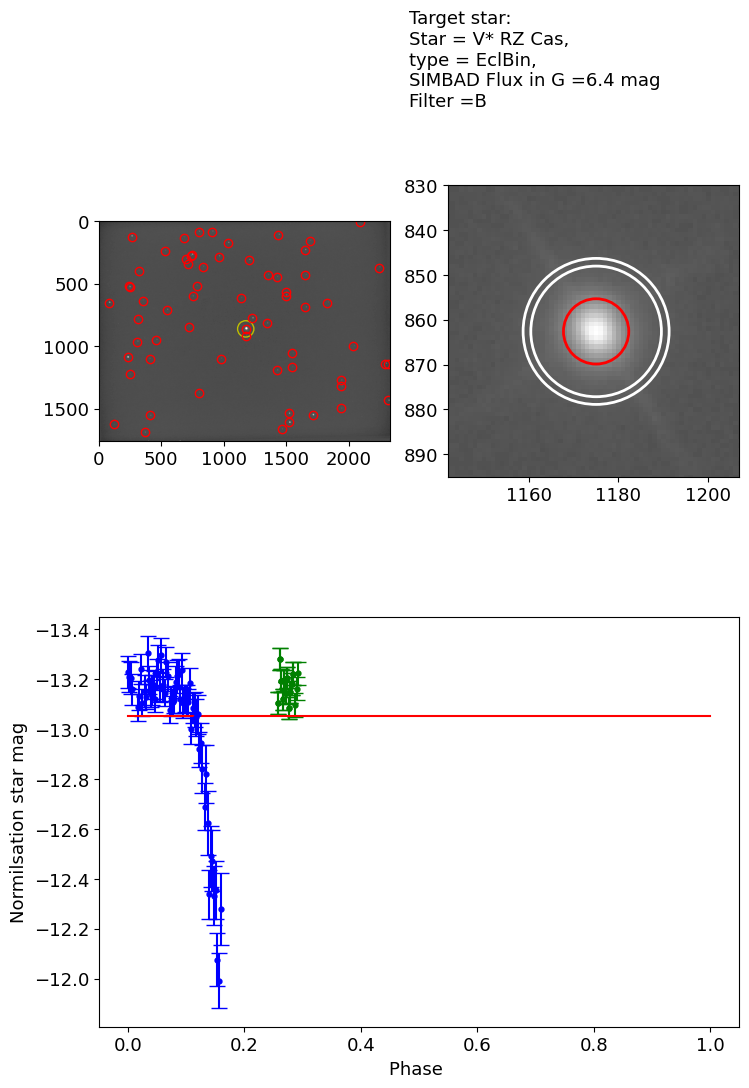

In [388]:
# A4 canvas
fig_width_cm = 21                                # A4 page
fig_height_cm = 29.7
inches_per_cm = 1 / 2.54                         # Convert cm to inches
fig_width = fig_width_cm * inches_per_cm         # width in inches
fig_height = fig_height_cm * inches_per_cm       # height in inches
fig_size = [fig_width, fig_height]

plt.rc('text', usetex=False) # so that LaTeX is not needed when creating a PDF with PdfPages later on
fig1 = plt.figure()
fig1.set_size_inches(fig_size)
plt.rcParams.update({'font.size':13})

#########

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(212)
#ax4 = plt.subplot(224)

an_outer = composite_df_stars_cut1['Anulus_out_radius (reduced pix)'][0]
nopixels = an_outer * 4

t=0
for ind in composite_df_stars_cut1.index:
    if composite_df_stars_cut1["MAIN_ID"][ind] == main_star:
        
        if t==0:
            star_name = composite_df_stars_cut1["MAIN_ID"][ind]
            star_type = composite_df_stars_cut1["OTYPE"][ind]
            star_flux_B = composite_df_stars_cut1["FLUX_B"][ind]
            if isinstance(star_name, str) == False:
                star_name = "not in SIMBAD"
                star_type = "not in SIMBAD"
            t=1
            ind_main = ind
                
           # if isinstance(star_flux_B, str) == False:
           #     star_flux_B = "not in SIMBAD"
            
fig1.suptitle('Target star: \n'+\
        'Star = '+ star_name\
        +',\n'+ 'type = '+star_type+',\n'\
        +'SIMBAD Flux in G ='+ str(star_flux_B)+' mag \n'\
        +'Filter ='+colour_list[0], fontsize=13,horizontalalignment='left')
            
ax1.cla() 
ax2.cla() 
ax3.cla()
            
x1 = composite_df_stars_cut1['xcenter'][ind_main]
y1 = composite_df_stars_cut1['ycenter'][ind_main]

aper_radius = composite_df_stars_cut1['Apperature_radius (reduced pix)'][ind_main]

an_inner = composite_df_stars_cut1['Anulus_in_radius (reduced pix)'][ind_main]
an_outer = composite_df_stars_cut1['Anulus_out_radius (reduced pix)'][ind_main]


ax1.imshow(composite_image,cmap=my_cmap,norm=LogNorm(vmin=1,vmax=0.1*composite_image.max()))
ax1.plot(composite_df_stars_cut1['xcenter'],composite_df_stars_cut1['ycenter'],'o',\
                     markerfacecolor="None",markeredgecolor='r')

circle4 = plt.Circle((composite_df_stars_cut1['xcenter'][ind_main],composite_df_stars_cut1['ycenter'][ind_main]), \
                                 nopixels, color='y',fill=False)
ax1.add_patch(circle4)


           # sub_image = composite_image

ax2.imshow(composite_image,\
                       cmap=my_cmap,norm=LogNorm(vmin=0.1*composite_image.min(),vmax=1*composite_image.max()))
ax2.set(ylim=[int(y1+nopixels/2),int(y1-nopixels/2)])
ax2.set(xlim=[int(x1-nopixels/2),int(x1+nopixels/2)])

circle1 = plt.Circle((composite_df_stars_cut1['xcenter'][ind_main],composite_df_stars_cut1['ycenter'][ind_main]), aper_radius, color='r',fill=False,lw=2)
circle2 = plt.Circle((composite_df_stars_cut1['xcenter'][ind_main],composite_df_stars_cut1['ycenter'][ind_main]), an_inner, color='w',fill=False,lw=2)
circle3 = plt.Circle((composite_df_stars_cut1['xcenter'][ind_main],composite_df_stars_cut1['ycenter'][ind_main]), an_outer, color='w',fill=False,lw=2)

ax2.add_patch(circle1)
ax2.add_patch(circle2)
ax2.add_patch(circle3)

            
            
            ##################
i=0
which_star = main_star
for file_night in file_nights:
    
    ax3.errorbar(df_data['Phase'].where( \
        (df_data['MAIN_ID'] == which_star) & \
        (df_data['File'].str.contains(file_night)) & \
        (df_data['Saturated'] == saturated)) , \
        df_data['Source_Mag_norm'].where( \
        (df_data['MAIN_ID'] == which_star) &  \
        (df_data['File'].str.contains(file_night)) & \
        (df_data['Saturated'] == saturated)),\
        yerr=df_data['Source_Mag_Error_norm'].where( \
        (df_data['MAIN_ID'] == which_star) & \
        (df_data['File'].str.contains(file_night)) & \
        (df_data['Saturated'] == saturated)), \
        label=file_night,\
        marker='.',             # marker used is a cicle 'o'. Could be crosses 'x', or squares 's', or 'none'
        markersize = 7,        # marker size
        color=plot_colours[i],          # overall colour I think
        ecolor=plot_colours[i],         # edge colour for you marker
        markerfacecolor=plot_colours[i],
        linestyle='none',       # no line joining markers, could be a line '-', or a dashed line '--'
        capsize=6,              # width of the end bit of the error bars, not too small nor too big please.
    )
    i=i+1

mean_mag = np.nanmean(df_data['Source_Mag_norm'].where( \
                    (df_data['MAIN_ID'] == which_star) &  \
                    (df_data['Saturated'] == saturated)))

ax3.plot([0,1],[mean_mag,mean_mag],'-r')

if main_star == "TYC 3023-1747-1":
    ax3.axis(ymin=mean_mag-0.2,ymax=mean_mag+0.2)
    

ax3.set_xlabel('Phase ')
ax3.set_ylabel('Normilsation star mag')
    
ax3.invert_yaxis()
            
         #   ax3.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()
pdf.savefig(fig1)
time.sleep(.02)

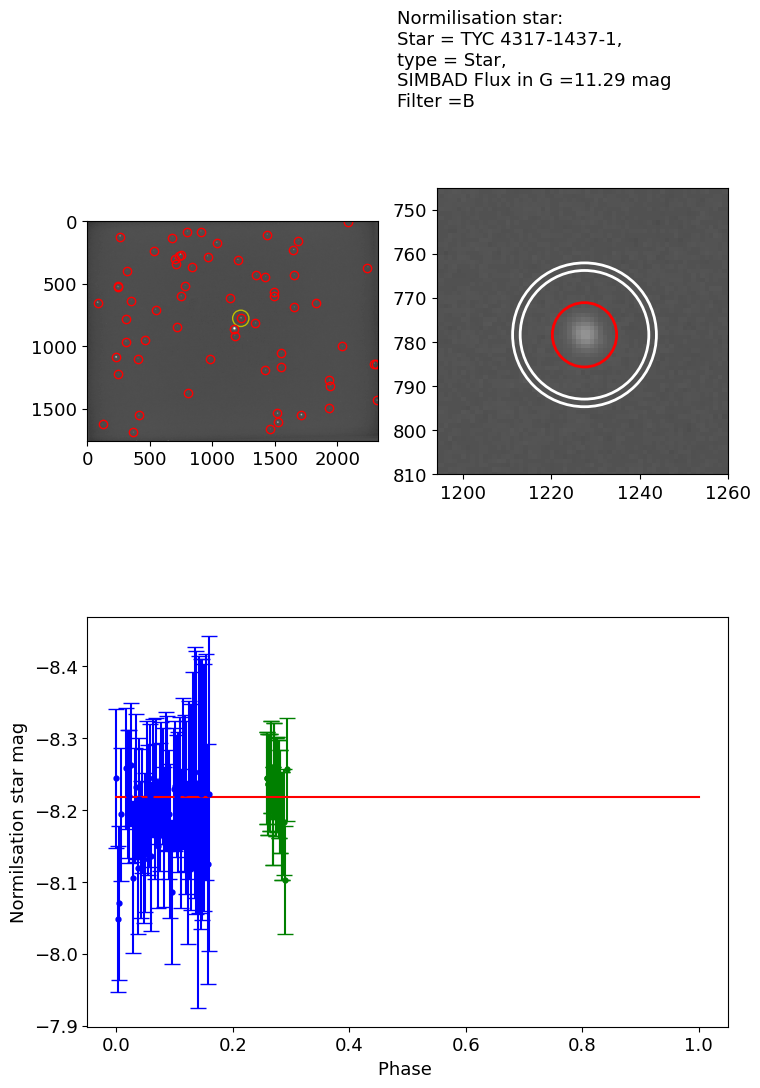

In [389]:
# A4 canvas
fig_width_cm = 21                                # A4 page
fig_height_cm = 29.7
inches_per_cm = 1 / 2.54                         # Convert cm to inches
fig_width = fig_width_cm * inches_per_cm         # width in inches
fig_height = fig_height_cm * inches_per_cm       # height in inches
fig_size = [fig_width, fig_height]

plt.rc('text', usetex=False) # so that LaTeX is not needed when creating a PDF with PdfPages later on
fig1 = plt.figure()
fig1.set_size_inches(fig_size)
plt.rcParams.update({'font.size':13})

#########

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(212)
#ax4 = plt.subplot(224)

an_outer = composite_df_stars_cut1['Anulus_out_radius (reduced pix)'][0]
nopixels = an_outer * 4

for ind in composite_df_stars_cut1.index:
    
#for ind in [0,1,2,3]:

    if composite_df_stars_cut1['Normilsation_star'][ind] == True:
        # Don't want to plot a Norm star that doesn't actually appear in an individual frames.
        if df_data['Source_Mag_norm'].where( \
                (df_data['id_ref'] == composite_df_stars_cut1['id'][ind]) &  \
                (df_data['Saturated'] == saturated)).count() > 0:
            
            star_name = composite_df_stars_cut1["MAIN_ID"][ind]
            star_type = composite_df_stars_cut1["OTYPE"][ind]
            star_flux_B = composite_df_stars_cut1["FLUX_B"][ind]
            if isinstance(star_name, str) == False:
                star_name = "not in SIMBAD"
                star_type = "not in SIMBAD"
                
           # if isinstance(star_flux_B, str) == False:
           #     star_flux_B = "not in SIMBAD"
            
            fig1.suptitle('Normilisation star: \n'+\
                  'Star = '+ star_name\
                    +',\n'+ 'type = '+star_type+',\n'\
                          +'SIMBAD Flux in G ='+ str(star_flux_B)+' mag \n'\
             +'Filter ='+colour_list[0], fontsize=13,horizontalalignment='left')
            
            ax1.cla() 
            ax2.cla() 
            ax3.cla()
          #  ax4.cla()
            
            x1 = composite_df_stars_cut1['xcenter'][ind]
            y1 = composite_df_stars_cut1['ycenter'][ind]

            aper_radius = composite_df_stars_cut1['Apperature_radius (reduced pix)'][ind]

            an_inner = composite_df_stars_cut1['Anulus_in_radius (reduced pix)'][ind]
            an_outer = composite_df_stars_cut1['Anulus_out_radius (reduced pix)'][ind]


            ax1.imshow(composite_image,cmap=my_cmap,norm=LogNorm(vmin=1,vmax=0.1*composite_image.max()))
            ax1.plot(composite_df_stars_cut1['xcenter'],composite_df_stars_cut1['ycenter'],'o',\
                     markerfacecolor="None",markeredgecolor='r')

            circle4 = plt.Circle((composite_df_stars_cut1['xcenter'][ind],composite_df_stars_cut1['ycenter'][ind]), \
                                 nopixels, color='y',fill=False)
            ax1.add_patch(circle4)


           # sub_image = composite_image

            ax2.imshow(composite_image,\
                       cmap=my_cmap,norm=LogNorm(vmin=0.1*composite_image.min(),vmax=1*composite_image.max()))
            ax2.set(ylim=[int(y1+nopixels/2),int(y1-nopixels/2)])
            ax2.set(xlim=[int(x1-nopixels/2),int(x1+nopixels/2)])

            circle1 = plt.Circle((composite_df_stars_cut1['xcenter'][ind],composite_df_stars_cut1['ycenter'][ind]), aper_radius, color='r',fill=False,lw=2)
            circle2 = plt.Circle((composite_df_stars_cut1['xcenter'][ind],composite_df_stars_cut1['ycenter'][ind]), an_inner, color='w',fill=False,lw=2)
            circle3 = plt.Circle((composite_df_stars_cut1['xcenter'][ind],composite_df_stars_cut1['ycenter'][ind]), an_outer, color='w',fill=False,lw=2)

            ax2.add_patch(circle1)
            ax2.add_patch(circle2)
            ax2.add_patch(circle3)

            
            
            ##################
            i=0
            for file_night in file_nights:


                ax3.errorbar(df_data['Phase'].where( \
                    (df_data['id_ref'] == composite_df_stars_cut1['id'][ind]) & \
                    (df_data['File'].str.contains(file_night)) & \
                    (df_data['Saturated'] == saturated)) , \
                    df_data['Source_Mag_norm'].where( \
                    (df_data['id_ref'] == composite_df_stars_cut1['id'][ind]) &  \
                    (df_data['File'].str.contains(file_night)) & \
                    (df_data['Saturated'] == saturated)),\
                    yerr=df_data['Source_Mag_Error_norm'].where( \
                    (df_data['id_ref'] == composite_df_stars_cut1['id'][ind]) & \
                    (df_data['File'].str.contains(file_night)) & \
                    (df_data['Saturated'] == saturated)), \
                    label = file_night,\
                    marker='.',             # marker used is a cicle 'o'. Could be crosses 'x', or squares 's', or 'none'
                    markersize = 7,        # marker size
                    color=plot_colours[i],          # overall colour I think
                    ecolor=plot_colours[i],         # edge colour for you marker
                    markerfacecolor=plot_colours[i],
                    linestyle='none',       # no line joining markers, could be a line '-', or a dashed line '--'
                    capsize=6,              # width of the end bit of the error bars, not too small nor too big please.
                )
                i=i+1


            mean_mag = np.nanmean(df_data['Source_Mag_norm'].where( \
                    (df_data['id_ref'] == composite_df_stars_cut1['id'][ind]) &  \
                    (df_data['Saturated'] == saturated)))

            ax3.plot([0,1],[composite_df_stars_cut1['Source_Mag'][ind],composite_df_stars_cut1['Source_Mag'][ind]],'-r')

            #ax3.axis(ymin=mean_mag-0.2,ymax=mean_mag+0.2)
            if main_star == "TYC 3023-1747-1":
                ax3.axis(ymin=mean_mag-0.2,ymax=mean_mag+0.2)
            ax3.set_xlabel('Phase ')
            ax3.set_ylabel('Normilsation star mag')
    
            ax3.invert_yaxis()
            
         #   ax3.legend(bbox_to_anchor=(1.1, 1.05))
            plt.show()
            pdf.savefig(fig1)
            time.sleep(.02)

pdf.close()